In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,Flatten,BatchNormalization,Dense,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [94]:
import numpy as np
import random
import pandas as pd 
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import splitfolders

In [95]:
#SPLITFOLDERS
data_dir = 'Cotton_Original_Dataset'
#division des jeux de donnee
splitfolders.ratio(data_dir,output='dataset',seed=555,ratio= (.8,.2))

Copying files: 6336 files [00:09, 665.69 files/s]


In [96]:
#generateur d'image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dataset = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_dataset = ImageDataGenerator(rescale=1./255)

In [97]:
training_set = train_dataset.flow_from_directory('dataset/train',target_size=(64,64),batch_size=16,class_mode='categorical')
val_set = train_dataset.flow_from_directory('dataset/val',target_size=(64,64),batch_size=16,class_mode='categorical')

Found 5068 images belonging to 5 classes.
Found 1268 images belonging to 5 classes.


In [98]:
# Convolution layer
classifier = Sequential()
classifier.add(Conv2D(16, (3, 3), input_shape=(64, 64, 3), activation='relu'))
classifier.add((BatchNormalization()))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add((Dropout(0.2)))

classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add((BatchNormalization()))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add((Dropout(0.3)))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add((BatchNormalization()))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten()) #transformer en vecteur

# Full connection
classifier.add(Dense(128, activation='relu'))
classifier.add((Dropout(0.3)))

classifier.add(Dense(5, activation='softmax'))

In [99]:
classifier.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 62, 62, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,717 (1.22 MB)

 Trainable params: 319,493 (1.22 MB)

 Non-trainable params: 224 (896.00 B)

In [100]:
classifier.compile(
    optimizer='adam',                # Algorithme d’optimisation
    loss='categorical_crossentropy', # Fonction de perte pour classification multiclasse
    metrics=['accuracy']             # Mesure de performance
)

In [101]:
checkpointer = ModelCheckpoint(filepath='model.keras',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

Early_stopping = EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=1e-5,verbose=1)
callbacks = [checkpointer,Early_stopping,reduce_lr]

In [102]:
models = classifier.fit(
    training_set,
    epochs=25,
    validation_data=val_set,
    callbacks=callbacks,
)


Epoch 1/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6268 - loss: 1.1430
Epoch 1: val_accuracy improved from None to 0.39353, saving model to model.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 189s 587ms/step - accuracy: 0.7005 - loss: 0.8252 - val_accuracy: 0.3935 - val_loss: 2.5761 - learning_rate: 0.0010
Epoch 2/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7803 - loss: 0.5701
Epoch 2: val_accuracy improved from 0.39353 to 0.71845, saving model to model.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.7893 - loss: 0.5452 - val_accuracy: 0.7185 - val_loss: 0.8420 - learning_rate: 0.0010
Epoch 3/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8096 - loss: 0.4617
Epoch 3: val_accuracy did not improve from 0.71845
317/317 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8112 - loss: 0.4715 - val_accuracy: 0.6443 - val_loss: 1.4385 - learning_rate: 0.0010
Epoch 4/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8077 - loss: 0.4666
Epoc

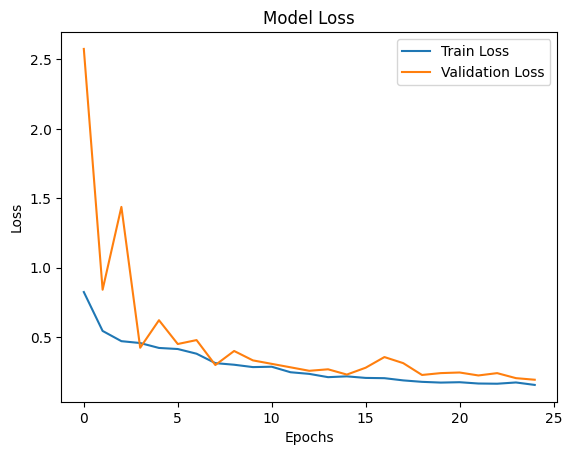

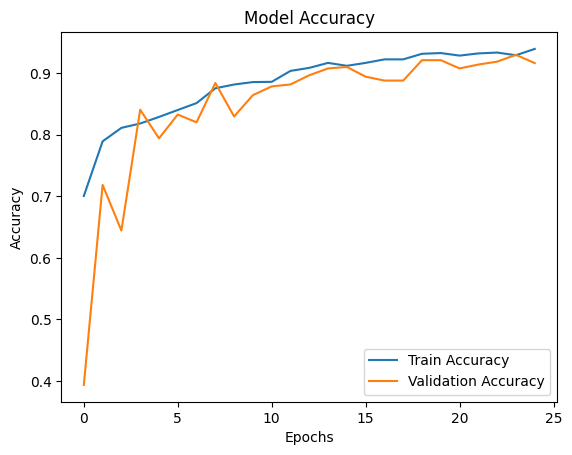

In [103]:
#evaluatio

# Tracer les courbes
import matplotlib.pyplot as plt

# Loss
plt.plot(models.history['loss'], label='Train Loss')
plt.plot(models.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(models.history['accuracy'], label='Train Accuracy')
plt.plot(models.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [104]:
training_set.class_indices

{'Alternaria Leaf Spot': 0,
 'Bacterial Blight': 1,
 'Fusarium Wilt': 2,
 'Healthy Leaf': 3,
 'Verticillium Wilt': 4}

In [105]:
from sklearn.metrics import classification_report
y_pred = classifier.predict(training_set)
y_pred = np.argmax(y_pred,axis=1)
y_pred
print(classification_report(training_set.classes,y_pred,target_names=training_set.class_indices))

317/317 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step
                      precision    recall  f1-score   support

Alternaria Leaf Spot       0.19      0.18      0.18       928
    Bacterial Blight       0.21      0.21      0.21       996
       Fusarium Wilt       0.21      0.22      0.22      1035
        Healthy Leaf       0.20      0.20      0.20      1078
   Verticillium Wilt       0.19      0.18      0.19      1031

            accuracy                           0.20      5068
           macro avg       0.20      0.20      0.20      5068
        weighted avg       0.20      0.20      0.20      5068



317/317 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step


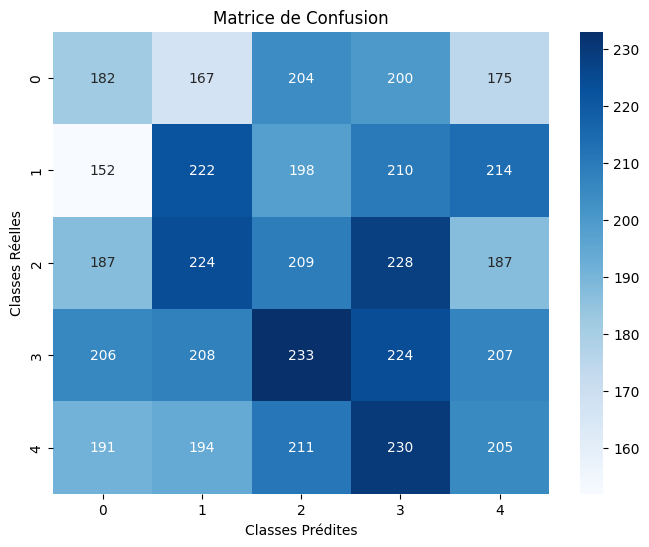

In [106]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Prédire sur l'ensemble d'entraînement ou de test
# Ici je prends training_set, mais tu peux utiliser val_set ou test_set
y_pred_prob = classifier.predict(training_set)
y_pred = np.argmax(y_pred_prob, axis=1)  # convertir softmax en classe

# 2️⃣ Obtenir les vraies classes
y_true = training_set.classes

# 3️⃣ Créer la matrice de confusion
cnf_matrix = confusion_matrix(y_true, y_pred)

# 4️⃣ Afficher avec seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Classes Prédites")
plt.ylabel("Classes Réelles")
plt.show()

In [107]:
training_set.class_names = list(training_set.class_indices.keys())
training_set.class_names


['Alternaria Leaf Spot',
 'Bacterial Blight',
 'Fusarium Wilt',
 'Healthy Leaf',
 'Verticillium Wilt']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


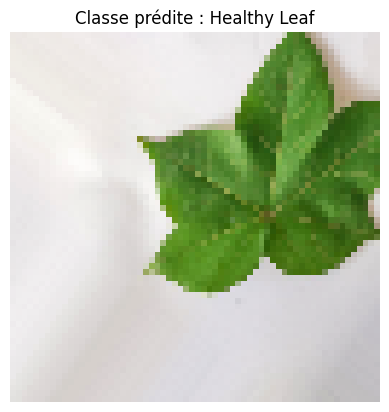

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Charger et préparer l'image
test_image = load_img('Cotton_Original_Dataset/Healthy Leaf/aug_healthy_(1).png', target_size=(64,64))
test_image_array = img_to_array(test_image)          # convertir en tableau numpy
test_image_array = np.expand_dims(test_image_array, axis=0)  # ajouter la dimension batch
test_image_array = test_image_array / 255.0          # normaliser

# Prédiction
pred_class_index = np.argmax(classifier.predict(test_image_array), axis=1)[0]

# Récupérer le nom de la classe
class_names = {v: k for k, v in training_set.class_indices.items()}
pred_class_name = class_names[pred_class_index]

# Afficher l'image et la classe prédite
plt.imshow(test_image)
plt.title(f"Classe prédite : {pred_class_name}")
plt.axis('off')
plt.show()


In [109]:
# Prédiction
result = classifier.predict(test_image_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [110]:
score = tf.nn.softmax(result)
print(score)

tf.Tensor([[0.14884758 0.14884758 0.14884758 0.40460962 0.14884758]], shape=(1, 5), dtype=float32)


In [111]:
print('cette image appartient a la classe {} avec {:.2f} % de confidence'.format(training_set.class_names[np.argmax(score)],100*np.max(score)))

cette image appartient a la classe Healthy Leaf avec 40.46 % de confidence


In [112]:
# Sauvegarder
classifier.save('cnn_model.h5')

# Recharger
from tensorflow.keras.models import load_model
classifier = load_model('cnn_model.h5')